## 파인튜닝
각각 학습시킨 분류기를 직렬화한 후 재학습

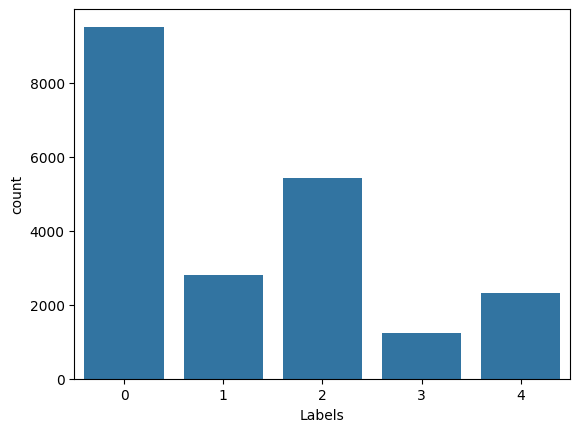

In [6]:
from ver4_journal.common.data.create_final_data import create_final_data

# train,val,test 데이터셋 만들기
final_data = create_final_data()
ECG_train = final_data[final_data['strat_fold'].isin([1, 2, 3, 4, 5, 6, 7, 8])].reset_index(drop=True)
ECG_val = final_data[final_data['strat_fold'] == 9].reset_index(drop=True)
ECG_test = final_data[final_data['strat_fold'] == 10].reset_index(drop=True)

ECG_train = ECG_train[ECG_train['Labels'].isin([0,1,2,3,4])].reset_index(drop=True)
ECG_val = ECG_val[ECG_val['Labels'].isin([0,1,2,3,4])].reset_index(drop=True)
ECG_test = ECG_test[ECG_test['Labels'].isin([0,1,2,3,4])].reset_index(drop=True)

In [7]:
from torch.utils.data import DataLoader
from ver4_journal.common.data.ECG_Data import ECG_Data

train_dataset = ECG_Data(ECG_train)
train_loader = DataLoader(train_dataset,batch_size=32, shuffle=True)

val_dataset=ECG_Data(ECG_val)
val_loader=DataLoader(val_dataset,batch_size=32, shuffle=True)

test_dataset=ECG_Data(ECG_test)
test_loader=DataLoader(test_dataset,batch_size=32, shuffle=True)

first_batch, label = next(iter(train_loader))

print(f"Batch shape: {first_batch.shape}")

print(len(train_loader), len(val_loader), len(test_loader))

Batch shape: torch.Size([32, 12, 1000])
532 67 68


In [8]:
import numpy as np
from ver4_journal.common.loss_func.FocalLoss import FocalLoss
from ver4_journal.common.network.BCResNets import BCResNets
import torch

# 모델의 순서 정의
sequence = [0, 2, 1, 4, 3]
num_models = len(sequence)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 모든 모델의 입력 채널 수 정의
in_channel = 12

num_epochs = 50
threshold = 0.5

# 저장된 각 모델을 로드하여 리스트에 저장
best_models = []
for dd in sequence:
    model_path = f'./common/best_models/{dd}model.pth'
    model = BCResNets(int(2 * 8), 1, in_channel).to(device)  # 모델 구조 동일하게 맞이기
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    best_models.append(model)

# 모든 모델의 파라미터를 하나의 리스트로 합치기
all_parameters = [param for model in best_models for param in model.parameters()]

# 옵티마이저 초기화
optimizer = torch.optim.Adam(all_parameters, lr=0.001)

focal_loss = FocalLoss(alpha=1.0, gamma=2.0, reduction='mean')

# 모델 재학습
for epoch in range(num_epochs):
    model.train()
    train_accuracy = []
    train_loss_sum = 0
    
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()

        y_true = []
        y_pred = []

        # 배치 내 각 샘플에 대해 모델을 순회 (필요할 때까지)
        batch_loss_sum = 0
        batch_correct = 0
        for i in range(data.size(0)):
            sample = data[i].unsqueeze(0)  # 배치 내의 개별 샘플 추출
            true_label = label[i]
            loss = 0
            class_label = None
            # 모든 모델을 순회하며 임계값을 넘는 첫 번째 모델 찾기
            for idx, model in enumerate(best_models):
                model_output = model(sample)
                output = torch.sigmoid(model_output).item()

                # Focal Loss 계산
                label_binary = torch.tensor([1.0 if true_label == sequence[idx] else 0.0], dtype=torch.float, device=device)
                loss += focal_loss(model_output.squeeze(-1).float(), label_binary)

                # 임계값을 넘으면 해당 클래스를 레이블로 지정하고 종료
                if output > threshold:
                    class_label = sequence[idx]
                    break

            # 임계값을 넘는 모델이 없는 경우 OTHER 클래스로 지정
            if class_label is None:
                class_label = 100  # OTHER 클래스(100)

            # 예측 결과 저장
            y_true.append(true_label.item())
            y_pred.append(class_label)

            # 역전파를 통해 손실을 최적화
            loss.backward()
            optimizer.step()

            batch_loss_sum += loss.item()
            if class_label == true_label.item():
                batch_correct += 1

        # 배치내 데이터에 대한 정확도 계산
        batch_accuracy = batch_correct / data.size(0)
        avg_batch_loss = batch_loss_sum / data.size(0)
        print(f'Batch {batch_idx + 1}/{len(train_loader)} - Loss: {avg_batch_loss:.4f}, Accuracy: {batch_accuracy:.2f}%')

        train_loss_sum += batch_loss_sum
        train_accuracy.append(batch_accuracy)

    # 학습 결과 출력
    avg_train_accuracy = np.mean(train_accuracy)
    avg_train_loss = train_loss_sum / len(train_loader.dataset)
    print(f'Epoch: {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.2f}%')

# 학습된 모델을 fine_tuning_model 폴더에 저장
for idx, model in enumerate(best_models):
    save_path = f'./fine_tuning_models/{idx}model.pth'
    torch.save(model.state_dict(), save_path)
    print(f'Model {sequence[idx]} saved as {save_path}')

Batch 1/532 - Loss: 1.1510, Accuracy: 0.59%
Batch 2/532 - Loss: 0.5233, Accuracy: 0.44%
Batch 3/532 - Loss: 0.2725, Accuracy: 0.47%
Batch 4/532 - Loss: 0.3212, Accuracy: 0.66%
Batch 5/532 - Loss: 0.1707, Accuracy: 0.75%
Batch 6/532 - Loss: 0.7847, Accuracy: 0.44%
Batch 7/532 - Loss: 0.7657, Accuracy: 0.31%
Batch 8/532 - Loss: 0.3236, Accuracy: 0.56%
Batch 9/532 - Loss: 0.3764, Accuracy: 0.56%
Batch 10/532 - Loss: 0.2071, Accuracy: 0.75%
Batch 11/532 - Loss: 0.3829, Accuracy: 0.59%
Batch 12/532 - Loss: 0.2659, Accuracy: 0.62%
Batch 13/532 - Loss: 0.3803, Accuracy: 0.59%
Batch 14/532 - Loss: 0.3567, Accuracy: 0.50%
Batch 15/532 - Loss: 0.3200, Accuracy: 0.69%
Batch 16/532 - Loss: 0.3195, Accuracy: 0.59%
Batch 17/532 - Loss: 0.3598, Accuracy: 0.66%
Batch 18/532 - Loss: 0.3174, Accuracy: 0.47%
Batch 19/532 - Loss: 0.3748, Accuracy: 0.38%
Batch 20/532 - Loss: 0.3161, Accuracy: 0.44%
Batch 21/532 - Loss: 0.3723, Accuracy: 0.34%
Batch 22/532 - Loss: 0.2932, Accuracy: 0.59%
Batch 23/532 - Loss

KeyboardInterrupt: 

In [ ]:
# 모든 분류기에 동일한 threshold를 적용

from ver4_journal.common.network.BCResNets import BCResNets
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# 모델 순서 정의
sequence = [0, 2, 1, 4, 3]
num_models = len(sequence)

# 각 모델을 불러와 AUC 테스트를 수행하는 코드
best_models = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 모델 입력 채널 수 정의
in_channel = 12

# 저장된 각 모델을 로드하여 리스트에 저장
for dd in sequence:
    model_path = f'./fine_tuning_models/{dd}model.pth'
    model = BCResNets(int(2 * 8), 1, in_channel).to(device)  # 모델 구조 동일하게 맞춰야 함
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    best_models.append(model)

# 임계값을 0.05씩 증가시키며 테스트
# 0.6부터는 STTC 분류가 안됨
thresholds = np.arange(0.2, 1.0, 0.05)

for threshold in thresholds:
    print("=====================================================================")
    print(f'\nTesting Serialized Model Pipeline with Threshold: {threshold:.2f}')
    y_true = []
    y_pred = []

    # 테스트 데이터셋을 연결된 모델에 사용
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)

            # 각 데이터 포인트별로 클래스 레이블을 결정
            for i in range(data.size(0)):  # 배치 내 각 샘플에 대해 반복
                sample = data[i].unsqueeze(0)  # 샘플 하나를 추출
                class_label = None

                # 모든 모델을 순차적으로 거치며, 특정 클래스에 속하는지 확인
                for idx, model in enumerate(best_models):
                    output = model(sample)
                    output = torch.sigmoid(output).item()  # 각 모델의 출력을 sigmoid로 변환하고 스칼라로 변환

                    # 임계값을 넘는 첫 번째 클래스를 찾아 레이블로 지정
                    if output > threshold:
                        class_label = sequence[idx]
                        break

                # 만약 모든 모델의 출력이 임계값 이하라면, OTHER 클래스로 설정
                if class_label is None:
                    class_label = 100  # OTHER 클래스는(100)

                # 최종 클래스 레이블 저장
                y_true.append(label[i].item())  # 샘플의 label 저장
                y_pred.append(class_label)  # 해당 샘플의 예측된 클래스 레이블 저장

    # Confusion Matrix 계산 및 시각화
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 100])
    print(f'임계값: {thresholds}')
    print(f'Confusion Matrix:\n{conf_matrix}')

    # Classification Report 추가 (OTHER 클래스 제외)
    print('\nClassification Report:')
    print(classification_report(y_true, y_pred, target_names=['NORM', 'STTC', 'MI', 'HYP', 'CD'], labels=[0, 1, 2, 3, 4], zero_division=0))
    print("=====================================================================")
    

In [ ]:
"""
AUC는 직렬화한 multi-stage에는 적합한 지표가 아니다.
왜냐하면, multi-stage는 각 분류기를 학습한 것이지 하나의 모델로 학습한게 아니라
각 stage의 확률의 합이 1이 된다는 보장이 없기 때문이다. (사용시 1이 안된다고 에러 뜸)
따라서 이 코드를 싫행시 에러가 뜨는걸 확인할 수 있다.

import torch
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 모델 순서 정의
sequence = [0, 2, 1, 4, 3]
num_models = len(sequence)

# 각 모델을 불러와 AUC 테스트를 수행하는 코드
best_models = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 모델 입력 채널 수 정의
in_channel = 12

# 저장된 각 모델을 로드하여 리스트에 저장
for dd in sequence:
    model_path = f'./best_models/{dd}model.pth'
    model = BCResNets(int(2 * 8), 1, in_channel).to(device)  # 모델 구조 동일하게 맞춰야 함
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    best_models.append(model)

# 연결된 모델을 사용하여 입력 데이터에 대해 분류를 수행하고 AUC 테스트 수행
print('\nTesting Serialized Model Pipeline')
y_true = []
y_pred_probs = []  # 각 클래스에 대한 확률 저장
y_pred = []  # 예측된 클래스 레이블 저장

# 테스트 데이터셋을 연결된 모델에 사용
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label.to(device)

        # 각 데이터 포인트별로 클래스 레이블을 결정
        for i in range(data.size(0)):  # 배치 내 각 샘플에 대해 반복
            sample = data[i].unsqueeze(0)  # 샘플 하나를 추출
            class_probs = torch.zeros(len(sequence))  # OTHER 클래스 제외한 각 클래스 확률 저장

            # 모든 모델을 순차적으로 거치며, 특정 클래스에 속하는지 확인
            for idx, model in enumerate(best_models):
                output = model(sample)
                output = torch.sigmoid(output).item()  # 각 모델의 출력을 sigmoid로 변환하고 스칼라로 변환
                class_probs[sequence[idx]] = output

            # 클래스 확률을 레이블 수로 나누어 정규화하여 AUC 계산에 사용
            normalized_probs = class_probs / len(sequence)  # 클래스 수로 나누어 정규화

            # 임계값(0.5)을 넘는 첫 번째 클래스를 찾아 레이블로 지정
            class_label = 100  # 기본적으로 OTHER 클래스로 설정
            for idx, prob in enumerate(class_probs):
                if prob > 0.5:
                    class_label = sequence[idx]
                    break

            # 최종 클래스 확률 저장 및 예측 레이블 저장
            y_true.append(label[i].item())  # 샘플의 label 저장
            y_pred_probs.append(normalized_probs.cpu().numpy())  # 해당 샘플의 예측된 클래스 확률 저장
            y_pred.append(class_label)  # 해당 샘플의 예측된 클래스 레이블 저장

# AUC 및 Confusion Matrix 계산
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred = np.array(y_pred)

# 다중 클래스 AUC 계산 (OTHER 클래스는 AUC 계산에 사용하지 않음)
try:
    auc_ovo = roc_auc_score(y_true, y_pred_probs, average='macro', multi_class='ovo', labels=[0, 1, 2, 3, 4])
    auc_ovr = roc_auc_score(y_true, y_pred_probs, average='macro', multi_class='ovr', labels=[0, 1, 2, 3, 4])
    print(f'Macro AUC OVO for Serialized Model: {auc_ovo:.4f}')
    print(f'Macro AUC OVR for Serialized Model: {auc_ovr:.4f}')
    print(f'Overall Performance Metrics: OVO AUC = {auc_ovo:.4f}, OVR AUC = {auc_ovr:.4f}')
except ValueError as e:
    print(f"AUC calculation error: {e}")

# Confusion Matrix 계산 및 시각화
conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 100])
print(f'Confusion Matrix:\n{conf_matrix}')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['NORM', 'STTC', 'MI', 'HYP', 'CD', 'OTHER'], 
            yticklabels=['NORM', 'STTC', 'MI', 'HYP', 'CD', 'OTHER'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Serialized Model')
plt.show()

# Classification Report 추가 (OTHER 클래스 제외)
print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=['NORM', 'STTC', 'MI', 'HYP', 'CD'], labels=[0, 1, 2, 3, 4]))
"""